# Web Mining and Applied NLP (CSIS 44-620)

## P7: Custom Final Project: Web Mining & NLP

### 
Author: Data-Git-Hub <br>
GitHub Project Repository Link: https://github.com/Data-Git-Hub/p7_web_compare <br>
26 July 2025 <br>

### Introduction
Need <br>

### Imports
Python libraries are collections of pre-written code that provide specific functionalities, making programming more efficient and reducing the need to write code from scratch. These libraries cover a wide range of applications, including data analysis, machine learning, web development, and automation. Some libraries, such as os, sys, math, json, and datetime, come built-in with Python as part of its standard library, providing essential functions for file handling, system operations, mathematical computations, and data serialization. Other popular third-party libraries, like `pandas`, `numpy`, `matplotlib`, `seaborn`, and `scikit-learn`, must be installed separately and are widely used in data science and machine learning. The extensive availability of libraries in Python's ecosystem makes it a versatile and powerful programming language for various domains. <br>

`beautifulsoup4` is a Python library used for parsing HTML and XML documents. It provides Pythonic methods for navigating, searching, and modifying the parse tree, making it ideal for web scraping tasks. BeautifulSoup is particularly useful for extracting data from web pages with inconsistent or poorly structured HTML. It works well with parsers like `html5lib` and `lxml`. <br>
https://www.crummy.com/software/BeautifulSoup/bs4/doc/ <br>

`Counter` is a subclass of Python’s `collections` module used for counting hashable objects. It allows for the quick and easy creation of frequency distributions, such as word or token counts in NLP tasks. <br>
https://docs.python.org/3/library/collections.html#collections.Counter <br>

`html5lib` is a pure-Python HTML parser designed to parse documents the same way modern web browsers do. It is especially useful for handling malformed or messy HTML. When used with `beautifulsoup4`, it provides robust parsing capabilities that help ensure accurate and tolerant extraction of web content. <br>
https://html5lib.readthedocs.io/en/latest/ <br>

`ipykernel` allows Jupyter Notebooks to run Python code by providing the kernel interface used to execute cells and handle communication between the front-end and the Python interpreter. <br>
https://ipykernel.readthedocs.io/en/latest/ <br>

`jupyterlab` is the next-generation user interface for Project Jupyter. It offers a flexible, extensible environment for interactive computing with support for code, markdown, visualizations, and terminals all within a tabbed workspace. JupyterLab enhances productivity by allowing users to organize notebooks, text editors, and data file viewers side by side. <br>
https://jupyterlab.readthedocs.io/en/stable/ <br>

`list` is a built-in Python data structure used to store ordered, mutable sequences of elements. Lists are highly versatile and are used extensively in Python programming for tasks ranging from data storage to iteration and transformation.
https://docs.python.org/3/tutorial/datastructures.html#more-on-lists

`Matplotlib` is a widely used data visualization library that allows users to create static, animated, and interactive plots. It provides extensive tools for generating various chart types, including line plots, scatter plots, histograms, and bar charts, making it a critical library for exploratory data analysis. <br>
https://matplotlib.org/stable/contents.html <br>

`notebook` is the Python package that powers the classic Jupyter Notebook interface. It provides a web-based environment for writing and running code in interactive cells, supporting rich media, visualizations, and markdown documentation. The notebook server manages the execution of kernels and renders notebooks in a browser. This tool is foundational for data analysis, teaching, and exploratory programming workflows. <br>
https://jupyter-notebook.readthedocs.io/en/stable/ <br>

`numpy` is a fundamental package for scientific computing in Python. It provides efficient support for numerical operations on large, multi-dimensional arrays and matrices, along with a wide range of mathematical functions such as mean, median, and standard deviation. It is widely used in data analysis, machine learning, and engineering.
https://numpy.org/

`Pandas` is a powerful data manipulation and analysis library that provides flexible data structures, such as DataFrames and Series. It is widely used for handling structured datasets, enabling easy data cleaning, transformation, and aggregation. Pandas is essential for data preprocessing in machine learning and statistical analysis. <br>
https://pandas.pydata.org/docs/ <br>

The `requests` library simplifies making HTTP requests in Python, allowing you to send GET, POST, and other types of requests to interact with APIs or web services. <br>
 https://docs.python-requests.org/en/latest/ <br>

`spaCy` is an advanced NLP library for Python that provides tools for tokenization, part-of-speech tagging, named entity recognition, and more, using pre-trained pipelines. <br>
https://spacy.io/ <br>

`spacytextblob` is a plugin for spaCy that adds sentiment analysis capabilities by integrating TextBlob's polarity and subjectivity scores into spaCy’s pipeline. <br>
https://github.com/AndrewIbrahim/spacy-textblob <br>

`TextBlob` is a Python library for processing textual data, built on top of `nltk` and `pattern`. It provides a simple API for common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, translation, and sentiment analysis. Its intuitive design and built-in sentiment scoring functions make it especially useful for quick prototyping and educational applications. <br>
https://textblob.readthedocs.io/en/dev/ <br>

In [53]:
# Imports and initial setup for NLP Article Comparison Notebook

import os
import pandas as pd
import requests
import pickle
import ast
import re
from bs4 import BeautifulSoup
from collections import Counter
from typing import List

import spacy
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
from textblob import TextBlob

# Load or download spaCy language model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

#### Section 1. Extract and Save About Us for Each Company's Website
We are writing code that extracts the full HTML content from the webpages at https://www.traderjoes.com/home/about-us, https://www.aldi.us/en/about-aldi/, https://www.albertsons.com/about-us.html, https://www.hy-vee.com/corporate/our-company/our-history/, and https://www.pigglywiggly.com/history/, then serializes the output to `.pkl` (or another appropriate format) for persistent storage. These files are saved in a directory called `dump_folder/` so they can be reliably loaded later for NLP processing and analysis. As part of the code, if we can not access the webpage, we will receive an error message, informing us of a failure to capture from the internet. <br> 

In [54]:
# Section 1: Extract and Save Article HTML with Header Fix, Timeout, and Logging

# Create a folder to store the dumped HTML if it doesn't exist
os.makedirs("dump_folder", exist_ok=True)

# User-Agent header to mimic a real browser
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/115.0.0.0 Safari/537.36"
    )
}

# URLs to extract (you can comment out REI if it keeps stalling)
urls = {
    "tradejoes": "https://www.traderjoes.com/home/about-us",
    "aldi": "https://www.aldi.us/en/about-aldi/",
    "albertsons": "https://www.albertsons.com/about-us.html",
    "hyvee": "https://www.hy-vee.com/corporate/our-company/our-history/",
    "pigglywiggly": "https://www.pigglywiggly.com/history/"
}

# Loop through and extract HTML content
for name, url in urls.items():
    try:
        print(f"\n Fetching {name.title()} - {url}")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        html_content = soup.prettify()

        # Save to pickle file
        with open(f"dump_folder/{name}.pkl", "wb") as f:
            pickle.dump(html_content, f)

        print(f"HTML from {url} saved to dump_folder/{name}.pkl")

    except requests.exceptions.Timeout:
        print(f"Timeout: Skipping {name.title()} due to slow response.")
    except Exception as e:
        print(f"Failed to fetch {name.title()} ({url}): {e}")


 Fetching Tradejoes - https://www.traderjoes.com/home/about-us
Failed to fetch Tradejoes (https://www.traderjoes.com/home/about-us): 403 Client Error: Forbidden for url: https://www.traderjoes.com/home/about-us

 Fetching Aldi - https://www.aldi.us/en/about-aldi/
HTML from https://www.aldi.us/en/about-aldi/ saved to dump_folder/aldi.pkl

 Fetching Albertsons - https://www.albertsons.com/about-us.html
HTML from https://www.albertsons.com/about-us.html saved to dump_folder/albertsons.pkl

 Fetching Hyvee - https://www.hy-vee.com/corporate/our-company/our-history/
HTML from https://www.hy-vee.com/corporate/our-company/our-history/ saved to dump_folder/hyvee.pkl

 Fetching Pigglywiggly - https://www.pigglywiggly.com/history/
HTML from https://www.pigglywiggly.com/history/ saved to dump_folder/pigglywiggly.pkl


#### Section 2. Load and Display About Us Text Conversion of Each Company's Website
We are writing code that reads the serialized HTML files from the `dump_folder/` created in Section 1. Using BeautifulSoup, we extract the plain text content from each company's "About Us" page with `.get_text()` and display a preview of the text. The full parsed text is then saved as a `.txt` file into a folder named `parse/` for later NLP analysis. <br>

#### NOTE - Preload Filter Dictionary

In [55]:
# Section 2: Load and Display Article Text

# Ensure output folder exists
os.makedirs("parse", exist_ok=True)

# List of company identifiers matching Section 1
companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

for company in companies:
    try:
        # Load raw HTML from the dumped pickle file
        with open(f"dump_folder/{company}.pkl", "rb") as f:
            html_content = pickle.load(f)

        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')
        plain_text = soup.get_text(separator=' ', strip=True)

        # Display a preview of the parsed text
        print(f"\n Parsed Text Preview for {company.capitalize()}:\n")
        print(plain_text[:1000] + "...\n")  # Print first 1000 characters

        # Save to a .txt file in the "parse" directory
        with open(f"parse/{company}.txt", "w", encoding="utf-8") as out_file:
            out_file.write(plain_text)

        print(f"✔ Plain text saved to parse/{company}.txt")

    except FileNotFoundError:
        print(f"File not found for {company}. Did the HTML fail to download in Section 1?")
    except Exception as e:
        print(f"Error processing {company}: {e}")
        
# Pre-Load custom exclusion list from file for both tokens and lemmas
exclude_path = "filters/bad_words.txt"  

if os.path.exists(exclude_path):
    with open(exclude_path, "r", encoding="utf-8") as f:
        custom_exclude = set(line.strip().lower() for line in f if line.strip())
    print(f"✔ Loaded {len(custom_exclude)} custom exclusion terms from {exclude_path}")
else:
    print(f"⚠️ Exclusion file not found at {exclude_path}. Continuing with empty list.")
    custom_exclude = set() 

File not found for tradejoes. Did the HTML fail to download in Section 1?

 Parsed Text Preview for Aldi:

About ALDI  | ALDI US Help Skip to Content Products Weekly Specials Featured Recipes Search Search Search Results Log in Cart Your Cart (0 products) Your cart is empty. But full of possibilities Let's go shopping Buy Again Restock your favorites! Subtotal ‎ Continue to Checkout Products Fresh Produce Fresh Fruit Fresh Vegetables Salad Kits Flowers and Plants Healthy Living Healthy Food & Snacks Fresh Meat & Seafood Fresh Beef Fresh Poultry Fresh Pork Fresh Sausage Fresh Seafood Other Meat & Plant-Based Proteins Snacks Chips, Crackers & Popcorn Cookies & Sweets Nuts & Dried Fruit Trail Mix Jerky & Dried Meat BBQ & Picnic Grilled Meat & Seafood Cookout Essentials BBQ & Picnic Supplies Frozen Foods Frozen Meat, Poultry & Seafood Frozen Vegetables Frozen Ice Cream & Desserts Frozen Fruit Frozen Breakfast Frozen Meals & Sides Frozen Appetizers & Snacks Frozen Pizza Frozen Sandwiches Da

#### Section 3. Analyze Most Frequent Tokens with spaCy
We are loading each company's parsed plain text from the `parse/` directory and analyzing it using a trained `spaCy` pipeline. We filter out tokens that are punctuation, stop words, or whitespace, and convert each token to lowercase. For each company, we extract and print the ten most frequent tokens along with their frequencies. We also save these top tokens in a new folder called `tps_report/` for later use in deliverables. <br>

In [56]:
# Section 3: Analyze Most Frequent Tokens with spaCy (Tabular Output)

os.makedirs("tps_report", exist_ok=True)

companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

# Dictionary to store top tokens for table display
token_table = {}

for company in companies:
    try:
        # Load parsed text
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Process with spaCy
        doc = nlp(text)

        # Filter and lowercase tokens
        filtered_tokens = [
            token.text.lower()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]

        # Count frequency and get top 10
        token_freq = Counter(filtered_tokens)
        top_tokens = token_freq.most_common(10)

        # Save to file
        with open(f"tps_report/{company}_tokens.txt", "w", encoding="utf-8") as out_file:
            for token, freq in top_tokens:
                out_file.write(f"{token}: {freq}\n")

        # Store formatted tokens for DataFrame
        token_table[company] = [f"{token} ({freq})" for token, freq in top_tokens]

    except FileNotFoundError:
        print(f" Could not find parse/{company}.txt")
        token_table[company] = ["N/A"] * 10
    except Exception as e:
        print(f" Error processing {company}: {e}")
        token_table[company] = ["Error"] * 10

# Convert to DataFrame for tabular display
token_df = pd.DataFrame(token_table, index=[f"Rank {i+1}" for i in range(10)])

# Display the token table
display(HTML("<h3> Top 10 Tokens per Company</h3>"))
display(token_df)

# Print saved confirmation
for company in companies:
    print(f"✔ Saved top tokens to tps_report/{company}_tokens.txt")
    
# Save token frequency table to CSV
token_df.to_csv("tps_report/token_frequency_table.csv", index=True)
    

 Could not find parse/tradejoes.txt


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,aldi (28),albertsons (19),hy (107),piggly (20)
Rank 2,N/A,new (15),care (17),vee (105),wiggly (20)
Rank 3,N/A,products (13),try (15),store (62),® (18)
Rank 4,N/A,opens (13),deli (14),stores (38),saunders (8)
Rank 5,N/A,tab (13),load (14),company (37),store (7)
Rank 6,N/A,fresh (11),frozen (10),iowa (35),grocery (7)
Rank 7,N/A,frozen (11),® (9),new (23),c&s (6)
Rank 8,N/A,cart (10),foods (8),opened (23),llc (5)
Rank 9,N/A,supplies (9),sorry (8),year (18),history (4)
Rank 10,N/A,food (8),canned (8),vredenburg (17),wholesale (4)


✔ Saved top tokens to tps_report/tradejoes_tokens.txt
✔ Saved top tokens to tps_report/aldi_tokens.txt
✔ Saved top tokens to tps_report/albertsons_tokens.txt
✔ Saved top tokens to tps_report/hyvee_tokens.txt
✔ Saved top tokens to tps_report/pigglywiggly_tokens.txt


#### Section 3.1. Analyze Most Frequent Tokens with spaCy with Filter
In this section, we extend our original token frequency analysis by applying an additional layer of filtering using a custom exclusion list. This list is stored in a text file located in the `filters/` directory and contains manually specified words that are either too generic or irrelevant for our domain-specific analysis (e.g., "company", "store", "product"). <br>

The process mirrors Section 3, where we use a trained `spaCy` pipeline to tokenize the plain text content from each company's parsed "About Us" page. We apply filters to remove punctuation, stop words, whitespace, and now, any word present in our exclusion list. The result is a more targeted and refined set of tokens that better represent meaningful themes and terminology used by each company. <br>

We extract the ten most frequent filtered tokens per company and display them in a comparative table. Additionally, the top tokens for each company are saved to individual files in the `tps_report/` directory using the `_tokens_filtered.txt` suffix, and the full table is saved as `token_frequency_table_filtered.csv` for future reference or analysis. <br>

In [57]:
# Section 3.1: Analyze Most Frequent Tokens with spaCy + Custom Exclusion Filter

os.makedirs("tps_report", exist_ok=True)

# Load exclusion list (if not loaded earlier)
exclude_path = "filters/bad_words.txt"
if os.path.exists(exclude_path):
    with open(exclude_path, "r", encoding="utf-8") as f:
        custom_exclude = set(line.strip().lower() for line in f if line.strip())
else:
    print(f" Exclusion file not found at {exclude_path}. Using empty list.")
    custom_exclude = set()

# Reuse companies list
token_table_filtered = {}
top_n = 10

for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        doc = nlp(text)

        # Apply filtering with custom exclusion
        filtered_tokens = [
            token.text.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and token.text.lower() not in custom_exclude
        ]

        token_freq = Counter(filtered_tokens)
        top_tokens = token_freq.most_common(top_n)

        # Save to new filtered file
        with open(f"tps_report/{company}_tokens_filtered.txt", "w", encoding="utf-8") as out_file:
            for token, freq in top_tokens:
                out_file.write(f"{token}: {freq}\n")

        token_table_filtered[company] = [f"{token} ({freq})" for token, freq in top_tokens]

    except FileNotFoundError:
        print(f" parse/{company}.txt not found.")
        token_table_filtered[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        token_table_filtered[company] = ["Error"] * top_n

# Create and display table
import pandas as pd
token_df_filtered = pd.DataFrame(token_table_filtered, index=[f"Rank {i+1}" for i in range(top_n)])
display(HTML("<h3> Top 10 Filtered Tokens per Company</h3>"))
display(token_df_filtered)

# Save table
token_df_filtered.to_csv("tps_report/token_frequency_table_filtered.csv", index=True)
print(" Filtered token frequency table saved to tps_report/token_frequency_table_filtered.csv")

# Confirmation
for company in companies:
    print(f" Saved filtered top tokens to tps_report/{company}_tokens_filtered.txt")


 parse/tradejoes.txt not found.


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,new (15),care (17),iowa (35),saunders (8)
Rank 2,N/A,products (13),try (15),new (23),c&s (6)
Rank 3,N/A,opens (13),deli (14),opened (23),history (4)
Rank 4,N/A,tab (13),load (14),year (18),wholesale (4)
Rank 5,N/A,fresh (11),frozen (10),vredenburg (17),grocers (4)
Rank 6,N/A,frozen (11),sorry (8),customers (17),brands (3)
Rank 7,N/A,cart (10),canned (8),introduced (16),contact (3)
Rank 8,N/A,supplies (9),sign (7),employees (13),korner (3)
Rank 9,N/A,snacks (8),unable (7),hyde (11),coloring (3)
Rank 10,N/A,meat (8),menu (7),des (11),book (3)


 Filtered token frequency table saved to tps_report/token_frequency_table_filtered.csv
 Saved filtered top tokens to tps_report/tradejoes_tokens_filtered.txt
 Saved filtered top tokens to tps_report/aldi_tokens_filtered.txt
 Saved filtered top tokens to tps_report/albertsons_tokens_filtered.txt
 Saved filtered top tokens to tps_report/hyvee_tokens_filtered.txt
 Saved filtered top tokens to tps_report/pigglywiggly_tokens_filtered.txt


#### Section 4. Analyze Most Frequent Lemmas with spaCy
We are analyzing the same parsed text from each company's "About Us" page using `spaCy`, but this time we're focusing on lemmas, the base or dictionary forms of words. After filtering out stop words, punctuation, and whitespace, we identify the Top 10 most frequent lemmas for each company. We print these results in a table and save both individual and tabular outputs to the `tps_report/` folder for later analysis. <br>

In [58]:
# Section 4: Analyze Most Frequent Lemmas with spaCy

lemma_table = {}
top_n = 10  # Top 10 lemmas

for company in companies:
    try:
        # Load parsed text
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        # Process with spaCy
        doc = nlp(text)

        # Filter and extract lemmas
        filtered_lemmas = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and not token.is_punct and not token.is_space
        ]

        # Count and get top N lemmas
        lemma_freq = Counter(filtered_lemmas)
        top_lemmas = lemma_freq.most_common(top_n)

        # Save to file
        with open(f"tps_report/{company}_lemmas.txt", "w", encoding="utf-8") as out_file:
            for lemma, freq in top_lemmas:
                out_file.write(f"{lemma}: {freq}\n")

        # Store for table
        lemma_table[company] = [f"{lemma} ({freq})" for lemma, freq in top_lemmas]

    except FileNotFoundError:
        print(f" Could not find parse/{company}.txt")
        lemma_table[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        lemma_table[company] = ["Error"] * top_n

# Create and display lemma frequency table
lemma_df = pd.DataFrame(lemma_table, index=[f"Rank {i+1}" for i in range(top_n)])

display(HTML("<h3> Top 10 Lemmas per Company</h3>"))
display(lemma_df)

# Save to CSV
lemma_df.to_csv("tps_report/lemma_frequency_table.csv", index=True)
print(" Lemma frequency table saved to tps_report/lemma_frequency_table.csv")

# Confirmation messages
for company in companies:
    print(f"✔ Saved top lemmas to tps_report/{company}_lemmas.txt")

 Could not find parse/tradejoes.txt


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,aldi (28),albertsons (18),hy (107),piggly (20)
Rank 2,N/A,price (15),care (17),vee (105),wiggly (20)
Rank 3,N/A,new (15),try (15),store (95),® (18)
Rank 4,N/A,product (14),deli (14),company (37),store (11)
Rank 5,N/A,open (13),load (14),iowa (35),grocery (7)
Rank 6,N/A,tab (13),shop (12),year (24),c&s (6)
Rank 7,N/A,fresh (11),frozen (10),new (23),llc (5)
Rank 8,N/A,frozen (11),® (9),open (23),saunder (5)
Rank 9,N/A,cart (10),store (9),customer (18),history (4)
Rank 10,N/A,shop (9),foods (8),employee (17),wholesale (4)


 Lemma frequency table saved to tps_report/lemma_frequency_table.csv
✔ Saved top lemmas to tps_report/tradejoes_lemmas.txt
✔ Saved top lemmas to tps_report/aldi_lemmas.txt
✔ Saved top lemmas to tps_report/albertsons_lemmas.txt
✔ Saved top lemmas to tps_report/hyvee_lemmas.txt
✔ Saved top lemmas to tps_report/pigglywiggly_lemmas.txt


#### Section 4.1. Analyze Most Frequent Lemmas with spaCy with Filter
In this section, we extend our lemma frequency analysis by applying the custom exclusion list loaded earlier from the `filters/` directory. This list contains terms we want to omit from our results due to their generic or domain-irrelevant nature. <br>

Using a trained `spaCy` pipeline, we extract and lemmatize tokens from each company's parsed text. We remove stop words, punctuation, whitespace, and any lemma present in the custom exclusion list. We then identify the ten most frequent filtered lemmas for each company and present them in a table for easy comparison. <br>

Each company's top lemmas are also saved individually in the `tps_report/` directory using a `_lemmas_filtered.txt` suffix, and the complete table is saved as `lemma_frequency_table_filtered.csv` for future analysis. <br.>

In [59]:
# Section 4.1: Analyze Most Frequent Lemmas with spaCy and Custom Exclusion Filter

os.makedirs("tps_report", exist_ok=True)

# Assume custom_exclude is already loaded from earlier cell
lemma_table_filtered = {}
top_n = 10

for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()

        doc = nlp(text)

        # Filter lemmas with custom exclusions
        filtered_lemmas = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and token.lemma_.lower() not in custom_exclude
        ]

        lemma_freq = Counter(filtered_lemmas)
        top_lemmas = lemma_freq.most_common(top_n)

        # Save individual lemma results
        with open(f"tps_report/{company}_lemmas_filtered.txt", "w", encoding="utf-8") as out_file:
            for lemma, freq in top_lemmas:
                out_file.write(f"{lemma}: {freq}\n")

        # Save to table
        lemma_table_filtered[company] = [f"{lemma} ({freq})" for lemma, freq in top_lemmas]

    except FileNotFoundError:
        print(f" parse/{company}.txt not found.")
        lemma_table_filtered[company] = ["N/A"] * top_n
    except Exception as e:
        print(f" Error processing {company}: {e}")
        lemma_table_filtered[company] = ["Error"] * top_n

# Create and display table
lemma_df_filtered = pd.DataFrame(lemma_table_filtered, index=[f"Rank {i+1}" for i in range(top_n)])
display(HTML("<h3> Top 10 Filtered Lemmas per Company</h3>"))
display(lemma_df_filtered)

# Save to CSV
lemma_df_filtered.to_csv("tps_report/lemma_frequency_table_filtered.csv", index=True)
print(" Filtered lemma frequency table saved to tps_report/lemma_frequency_table_filtered.csv")

# Confirmation
for company in companies:
    print(f" Saved filtered top lemmas to tps_report/{company}_lemmas_filtered.txt")

 parse/tradejoes.txt not found.


,tradejoes,aldi,albertsons,hyvee,pigglywiggly
Rank 1,N/A,price (15),care (17),iowa (35),c&s (6)
Rank 2,N/A,new (15),try (15),year (24),saunder (5)
Rank 3,N/A,product (14),deli (14),new (23),history (4)
Rank 4,N/A,open (13),load (14),open (23),wholesale (4)
Rank 5,N/A,tab (13),shop (12),customer (18),grocers (4)
Rank 6,N/A,fresh (11),frozen (10),employee (17),service (4)
Rank 7,N/A,frozen (11),sorry (8),vredenburg (17),brands (3)
Rank 8,N/A,cart (10),canned (8),introduce (16),contact (3)
Rank 9,N/A,shop (9),sign (7),service (11),korner (3)
Rank 10,N/A,supplies (9),unable (7),hyde (11),coloring (3)


 Filtered lemma frequency table saved to tps_report/lemma_frequency_table_filtered.csv
 Saved filtered top lemmas to tps_report/tradejoes_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/aldi_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/albertsons_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/hyvee_lemmas_filtered.txt
 Saved filtered top lemmas to tps_report/pigglywiggly_lemmas_filtered.txt


#### Section 4.2. Comparison Between Tokens and Lemmas with Filter
In this section, we are comparing the most frequent tokens and lemmas extracted from each company's “About Us” web page after applying a custom exclusion filter. This filter removes non-informative or brand-specific terms (such as "store," "food," or company names) that would otherwise dominate the frequency analysis due to the nature of grocery industry marketing content.

By processing both tokens and lemmas through the same filtering criteria, we aim to better understand how lemmatization (reducing words to their base form) changes the representation of key concepts across the companies. Lemmatization groups together word variants (e.g., "opens" and "open"), which may highlight more general themes than raw token counts.

We load the filtered top 10 tokens and lemmas (saved from previous sections) for each company from the `tps_report/` directory and organize them into a side-by-side comparison table. This allows us to directly observe differences in word representation and frequency between the two approaches. The final comparison is saved to a CSV file for inclusion in the final deliverable.

In [60]:
# Ensure the report folder exists
os.makedirs("tps_report", exist_ok=True)

# Companies to compare
companies = ["tradejoes", "aldi", "albertsons", "hyvee", "pigglywiggly"]

# Initialize comparison data
comparison_data = {}

for company in companies:
    token_path = f"tps_report/{company}_tokens_filtered.txt"
    lemma_path = f"tps_report/{company}_lemmas_filtered.txt"
    
    try:
        # Read token file (formatted as "word: freq")
        with open(token_path, "r", encoding="utf-8") as f:
            token_lines = f.readlines()
        tokens = [line.strip() for line in token_lines if ":" in line]
        
        # Read lemma file (formatted as "word: freq")
        with open(lemma_path, "r", encoding="utf-8") as f:
            lemma_lines = f.readlines()
        lemmas = [line.strip() for line in lemma_lines if ":" in line]

        # Normalize both lists to the same length
        max_len = max(len(tokens), len(lemmas))
        tokens += [""] * (max_len - len(tokens))
        lemmas += [""] * (max_len - len(lemmas))

        # Store in comparison data
        comparison_data[company] = {
            "Top Tokens": tokens,
            "Top Lemmas": lemmas
        }

    except Exception as e:
        print(f" Could not load data for {company}: {e}")
        comparison_data[company] = {
            "Top Tokens": ["N/A: 0"] * 10,
            "Top Lemmas": ["N/A: 0"] * 10
        }

# Build DataFrame for side-by-side comparison
comparison_rows = []
for i in range(10):  # Assuming top 10
    row = {}
    for company in companies:
        row[f"{company}_token"] = comparison_data[company]["Top Tokens"][i]
        row[f"{company}_lemma"] = comparison_data[company]["Top Lemmas"][i]
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows, index=[f"Rank {i+1}" for i in range(10)])

# Display and Save
from IPython.display import display, HTML
display(HTML("<h3>Comparison Between Top Tokens and Lemmas (Filtered)</h3>"))
display(comparison_df)

# Save to CSV
comparison_df.to_csv("tps_report/token_vs_lemma_comparison_filtered.csv")
print(" Comparison table saved to tps_report/token_vs_lemma_comparison_filtered.csv")

 Could not load data for tradejoes: [Errno 2] No such file or directory: 'tps_report/tradejoes_tokens_filtered.txt'


,tradejoes_token,tradejoes_lemma,aldi_token,aldi_lemma,albertsons_token,albertsons_lemma,hyvee_token,hyvee_lemma,pigglywiggly_token,pigglywiggly_lemma
Rank 1,N/A: 0,N/A: 0,new: 15,price: 15,care: 17,care: 17,iowa: 35,iowa: 35,saunders: 8,c&s: 6
Rank 2,N/A: 0,N/A: 0,products: 13,new: 15,try: 15,try: 15,new: 23,year: 24,c&s: 6,saunder: 5
Rank 3,N/A: 0,N/A: 0,opens: 13,product: 14,deli: 14,deli: 14,opened: 23,new: 23,history: 4,history: 4
Rank 4,N/A: 0,N/A: 0,tab: 13,open: 13,load: 14,load: 14,year: 18,open: 23,wholesale: 4,wholesale: 4
Rank 5,N/A: 0,N/A: 0,fresh: 11,tab: 13,frozen: 10,shop: 12,vredenburg: 17,customer: 18,grocers: 4,grocers: 4
Rank 6,N/A: 0,N/A: 0,frozen: 11,fresh: 11,sorry: 8,frozen: 10,customers: 17,employee: 17,brands: 3,service: 4
Rank 7,N/A: 0,N/A: 0,cart: 10,frozen: 11,canned: 8,sorry: 8,introduced: 16,vredenburg: 17,contact: 3,brands: 3
Rank 8,N/A: 0,N/A: 0,supplies: 9,cart: 10,sign: 7,canned: 8,employees: 13,introduce: 16,korner: 3,contact: 3
Rank 9,N/A: 0,N/A: 0,snacks: 8,shop: 9,unable: 7,sign: 7,hyde: 11,service: 11,coloring: 3,korner: 3
Rank 10,N/A: 0,N/A: 0,meat: 8,supplies: 9,menu: 7,unable: 7,des: 11,hyde: 11,book: 3,coloring: 3


 Comparison table saved to tps_report/token_vs_lemma_comparison_filtered.csv


#### Section 4.3. Polarity Scores for Each Company's Website
In this section, we analyze the overall sentiment polarity of each company’s "About Us" webpage using the `TextBlob` library. Polarity scores range from -1.0 (very negative) to +1.0 (very positive). We compute one polarity score per company by loading the parsed text from the `parse/` folder.

To help visualize how these companies compare in sentiment, we generate a quadrant scatter plot showing each company’s polarity on the vertical axis and text length (as a proxy for verbosity or detail) on the horizontal axis. This provides insight into how positive or negative their messaging is and how much content they include.

We omit Trader Joe’s due to missing data and save the resulting visualization as a `.jpg` file to the `tps_report/` folder.

Aldi — Polarity: 0.204, Length: 1234 words
Albertsons — Polarity: 0.0866, Length: 1542 words
Hyvee — Polarity: 0.1426, Length: 3558 words
Pigglywiggly — Polarity: 0.1043, Length: 600 words


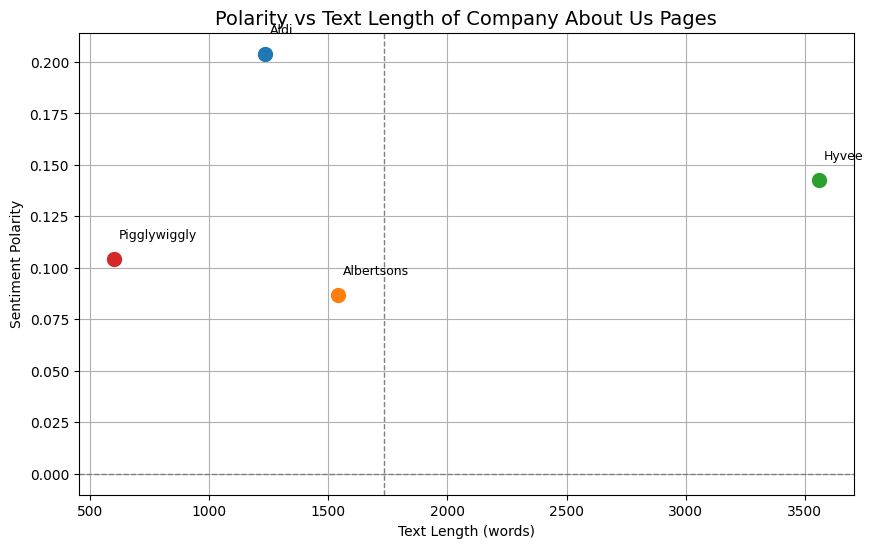


✔ Polarity quadrant plot saved to: tps_report/polarity_quadrant_plot.jpg


In [61]:
os.makedirs("tps_report", exist_ok=True)

# Companies to evaluate (drop 'tradejoes')
companies = ["aldi", "albertsons", "hyvee", "pigglywiggly"]

polarity_scores = {}
text_lengths = {}

# Compute polarity and text length
for company in companies:
    try:
        with open(f"parse/{company}.txt", "r", encoding="utf-8") as f:
            text = f.read()
            blob = TextBlob(text)
            polarity_scores[company] = round(blob.sentiment.polarity, 4)
            text_lengths[company] = len(text.split())

            print(f"{company.capitalize()} — Polarity: {polarity_scores[company]}, Length: {text_lengths[company]} words")
    except FileNotFoundError:
        print(f" Could not load parse/{company}.txt")
        polarity_scores[company] = None
        text_lengths[company] = 0

# Prepare scatter plot
x = [text_lengths[c] for c in companies]
y = [polarity_scores[c] for c in companies]

plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(sum(x)/len(x), color='gray', linestyle='--', linewidth=1)

for i, company in enumerate(companies):
    plt.scatter(x[i], y[i], s=100)
    plt.text(x[i]+20, y[i]+0.01, company.capitalize(), fontsize=9)

plt.title("Polarity vs Text Length of Company About Us Pages", fontsize=14)
plt.xlabel("Text Length (words)")
plt.ylabel("Sentiment Polarity")
plt.grid(True)

# Save and show
plot_path = "tps_report/polarity_quadrant_plot.jpg"
plt.savefig(plot_path, format="jpg", dpi=300)
plt.show()

print(f"\n✔ Polarity quadrant plot saved to: {plot_path}")

The polarity and length metrics of each company's "About Us" webpage offer insight into the tone and depth of their brand narratives. Among the four companies analyzed, Aldi exhibits the highest sentiment polarity at 0.204, indicating a generally more positive and affirming tone, even though its content length (1234 words) is moderate. In contrast, Hy-Vee provides the longest narrative (3558 words) but with a slightly lower polarity score (0.1426), suggesting that while the message is still positive, it is more nuanced or possibly includes more neutral or factual elements. Albertsons and Piggly Wiggly both have lower polarity values (0.0866 and 0.1043, respectively), and Piggly Wiggly, notably, has the shortest narrative (600 words), which may limit emotional expressiveness or the breadth of their storytelling.

In sentiment analysis, longer texts tend to have a natural polarity dampening effect due to a mix of positive, neutral, and negative phrases (Liu, 2012). This could explain why Hy-Vee, despite having significantly more content, does not have the highest sentiment score. Moreover, sentiment polarity is context-sensitive; corporate communications may aim for neutrality or professionalism, which affects average polarity scores (Pang & Lee, 2008). Aldi’s higher polarity score may result from strategic word choices focused on affordability, customer care, or community values — themes that tend to use more positively connotated language.

---

### References:
Liu, B. (2012). Sentiment Analysis and Opinion Mining. Morgan & Claypool Publishers. https://doi.org/10.2200/S00416ED1V01Y201204HLT016 <br>

Pang, B., & Lee, L. (2008). Opinion mining and sentiment analysis. Foundations and Trends® in Information Retrieval, 2(1–2), 1–135. https://doi.org/10.1561/1500000011 <br.>
